In [1]:
import json
import os
import mimetypes

import pandas as pd

from plot_from_dict import *

C:\Users\Florent\AppData\Local\Temp\ipykernel_16900\2103612586.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
%cd ..
%pwd

c:\Users\Florent\GNN\ML_research_seminar


c:\Users\Florent\anaconda3\envs\testenc\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'c:\\Users\\Florent\\GNN\\ML_research_seminar'

# I. Preparation of the data

In [3]:
list_dict = []

path_results = "./model/results/"

with os.scandir(path_results) as entries:

    for entry in entries:

        if entry.is_file() :

          name = entry.name

          if 'json' in mimetypes.guess_type(name)[0] :

            with open(f"{path_results}/{name}", 'r') as file:

              data = json.load(file)

            list_dict.append(data)

In [4]:
path_homophily = "./homophily/homophily_data.csv"

df_homophily = pd.read_csv(path_homophily)
df_homophily['Name_Dataset'] = df_homophily['Name_Dataset'].apply(lambda s : s.upper())
df_homophily.head()

,Name_Dataset,Seed,Homophily_edge_train,Homophily_edge_test,Homophily_node_train,Homophily_node_test,Homophily_edge_insensitive_train,Homophily_edge_insensitive_test
0,MUTAG,12345,0.721,0.722,0.661,0.662,0.034,0.035
1,ENZYMES,12345,0.667,0.660,0.665,0.664,0.370,0.399
2,PROTEINS,12345,0.657,0.654,0.652,0.648,0.372,0.367
3,PATTERN,12345,0.333,0.333,0.333,0.333,0.000,0.000
4,CLUSTER,12345,0.905,0.905,0.901,0.901,0.009,0.000


In [5]:
# adding the homophily values to the entries of each dictionnary of list_dict
for dic in list_dict :
  name_dataset = dic["dataset"]

  try :
    dic["homophily"] = df_homophily.loc[df_homophily['Name_Dataset'] == name_dataset, 'Homophily_edge_train'].values[0]
  except IndexError :
    dic["homophily"] = 0.

In [6]:
list_dict[0].keys()

dict_keys(['dataset', 'max_epochs', 'patience', 'lr', 'convolution_layer', 'global_pooling_layer', 'local_pooling_layer', 'alpha', 'batch_size', 'nb_parameters', 'mean_accuracy', 'std_accuracy', 'homophily'])

In [7]:
# creating a variable of pooling that takes into account
for dic in list_dict:
    dic["pooling"] = f"{dic['global_pooling_layer']}+{dic['local_pooling_layer']}"

# II. Scatter plot in 3D

In [8]:
# in order to have an interactive voew for the following plots
%matplotlib widget

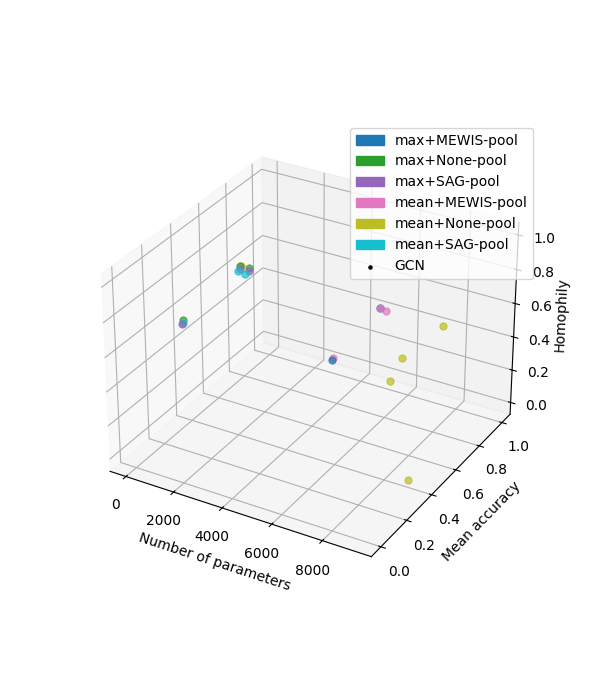

In [30]:
plot_from_dict(list_dict, (6,7), alpha=0.7, s=100)

# III. Pairplot

In [28]:
[dic[]]

[{'dataset': 'CIFAR10',
  'max_epochs': 20,
  'patience': 20,
  'lr': 0.005,
  'convolution_layer': 'GCN',
  'global_pooling_layer': 'mean',
  'local_pooling_layer': None,
  'alpha': '1e-2',
  'batch_size': 64,
  'nb_parameters': 9226,
  'mean_accuracy': 0.2773444444444445,
  'std_accuracy': 0.00332385689995192,
  'homophily': 0.779,
  'pooling': 'mean+None'},
 {'dataset': 'ENZYMES',
  'max_epochs': 200,
  'patience': 20,
  'lr': 0.005,
  'convolution_layer': 'GCN',
  'global_pooling_layer': 'max',
  'local_pooling_layer': 'MEWIS',
  'alpha': '1e-2',
  'batch_size': 64,
  'nb_parameters': 6569,
  'mean_accuracy': 0.26666666666666666,
  'std_accuracy': 0.03908679799852858,
  'homophily': 0.667,
  'pooling': 'max+MEWIS'},
 {'dataset': 'ENZYMES',
  'max_epochs': 200,
  'patience': 20,
  'lr': 0.005,
  'convolution_layer': 'GCN',
  'global_pooling_layer': 'max',
  'local_pooling_layer': None,
  'alpha': '1e-2',
  'batch_size': 64,
  'nb_parameters': 710,
  'mean_accuracy': 0.24,
  'std_acc

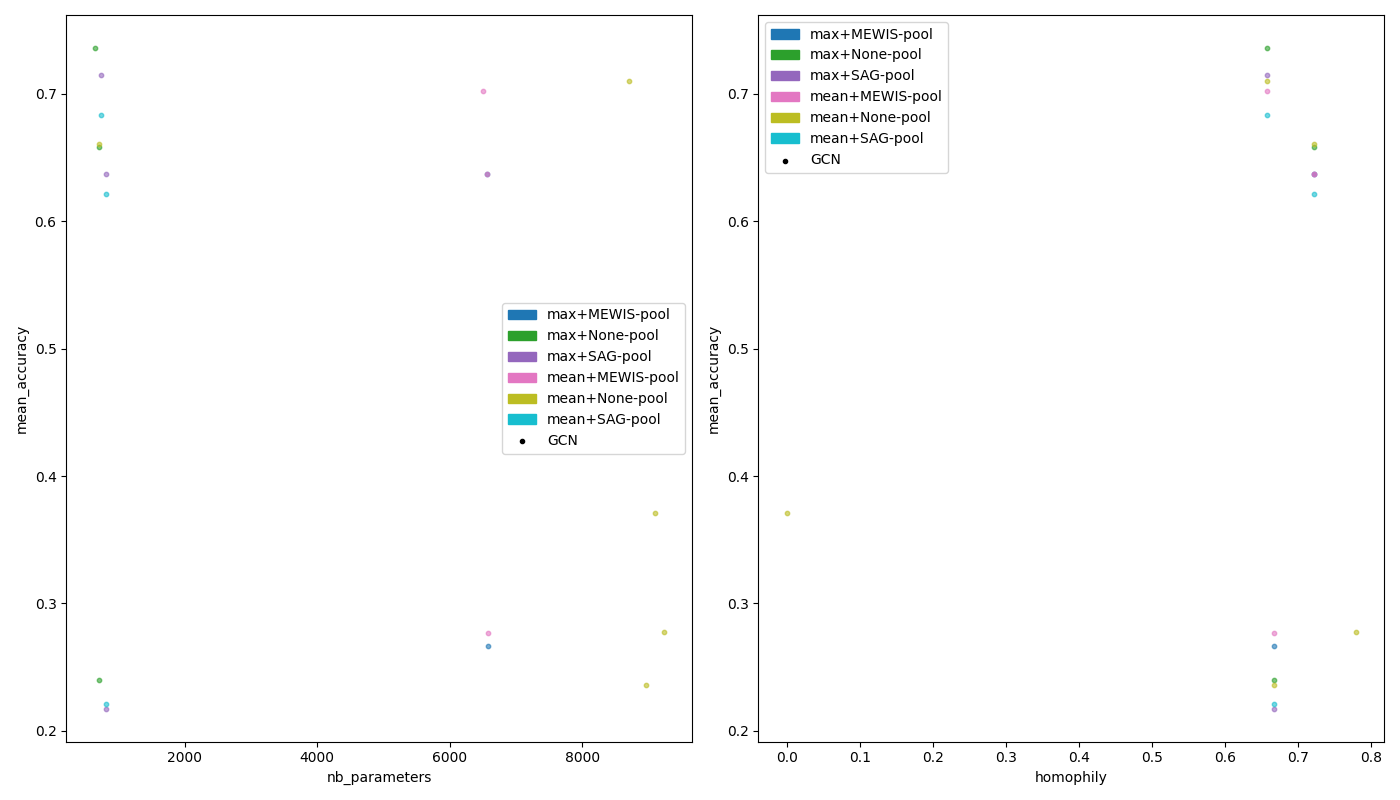

In [29]:
pairplot_from_dict(list_dict, 
                   [('nb_parameters','mean_accuracy'),
                    ('homophily','mean_accuracy')],
                    (1,2),
                    figsize=(14,8),
                    alpha=0.6,
                    s=40)

In [11]:
poolings, color_mapping, colors = get_pooling_mapping(list_dict)
convolutions, shape_mapping, shapes = get_convolution_mapping(list_dict)

In [13]:
poolings

['mean+None',
 'max+MEWIS',
 'max+None',
 'max+SAG',
 'mean+MEWIS',
 'mean+None',
 'mean+SAG',
 'mean+None',
 'max+MEWIS',
 'max+None',
 'max+SAG',
 'mean+MEWIS',
 'mean+None',
 'mean+SAG',
 'max+None',
 'max+SAG',
 'mean+MEWIS',
 'mean+None',
 'mean+SAG']

In [14]:
convolutions = np.unique(convolutions)

In [15]:
x = np.arange(len(convolutions))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

NameError: name 'penguin_means' is not defined

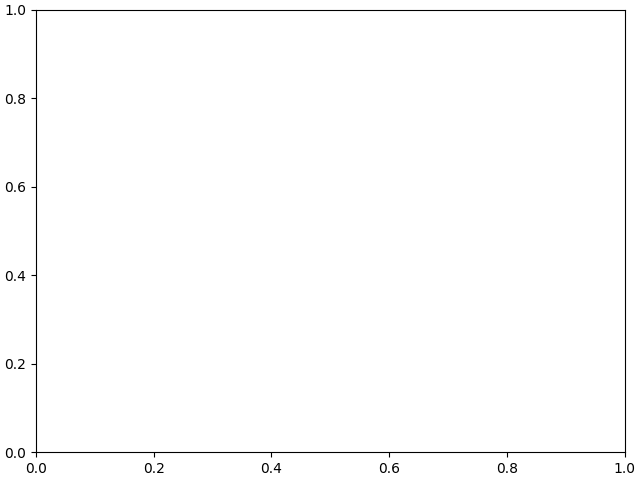

In [16]:
fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 250)

plt.show()